# Определение стоимости автомобилей

<b>Описание проекта</b>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

<b>Цель проекта</b>

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

<b>Задачи проекта</b>

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Разделим наш проект на этапы:</b>

1. Подготовка данных

    [ Загрузка необходимых библиотек](#step_1)
    
    [ Загрузка данных, их анализ и предобработка](#step_2)

[2. Обучение моделей](#step_3)

   [ Обучение модели линейной регрессии](#step_4)
   
   [ Обучение модели дерева решений](#step_5)
   
   [ Обучение модели случайного дерева](#step_6)
   
   [ Обучение модели CatBoostRegressor](#step_7)
   
   [ Обучение модели LGBMRegressor](#step_8)
   
   [ Выод по данному этапу](#step_9)

[3. Анализ моделей](#step_10)

[4. Общий вывод](#step_11)

## Подготовка данных

<a id="step_1"></a>
Загрузим необходимые библиотеки

In [1]:
# pip install catboost

In [2]:
# pip install lightgbm

In [3]:
import pandas as pd # для работы с данными
import time
from typing import Any
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer # для генерации объекта скоринга
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.model_selection import GridSearchCV # для получения наилучших параметров модели
from sklearn.model_selection import train_test_split # для разбиения данных на выборки
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler # для маштабирования данных
from sklearn.tree import DecisionTreeRegressor

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

<a id="step_2"></a>
Загрузим наши данные

In [5]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

Функция для первичного просмотра загруженных данных

In [6]:
def first_look(df: pd.DataFrame, limit_na_category: int=10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print('------------- Типы данных ------------')
    print(df.info())
    print('')
    print('')
    print('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2),\
                  '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    # ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Категориальные признаки ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

Посмотрим на наши данные

In [7]:
first_look(df)

------------- Первые 5 строк ------------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 n

Наши данные представляют из себя таблицу из 16 столбцов и 354 369 строк, из которых:

Признаки

•	DateCrawled — дата скачивания анкеты из базы (без пропусков данных)

•	VehicleType — тип автомобильного кузова (37 490 строк пропусков)

•	RegistrationYear — год регистрации автомобиля

•	Gearbox — тип коробки передач (19 833 строк пропусков)

•	Power — мощность (л. с.)

•	Model — модель автомобиля (19 705 строк пропусков)

•	Kilometer — пробег (км)

•	RegistrationMonth — месяц регистрации автомобиля

•	FuelType — тип топлива (32 895 строк пропусков) (petrol и gasoline - одно и тоже)

•	Brand — марка автомобиля

•	NotRepaired — была машина в ремонте или нет (71 154 строк пропусков)

•	DateCreated — дата создания анкеты

•	NumberOfPictures — количество фотографий автомобиля (всего одно значение - 0)

•	PostalCode — почтовый индекс владельца анкеты (пользователя)

•	LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

В данных имеются дубликаты (4 шт.)

Также имеется 5 колонок с категориальными признаками

Из представленных нам данных в последующей работе нам необходимы не все столбцы с данными, а именно не несут полезной информации:

DateCrawled

PostalCode

LastSeen

NumberOfPictures

Удалим их из наших данных

In [8]:
df = df.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

Первым по списку у нас идет столбец с целевым признаком, рассмотрим данным в нем внимательно

In [9]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Видим нулевые значения, посмотрим поближе наше распределение

<AxesSubplot:ylabel='Frequency'>

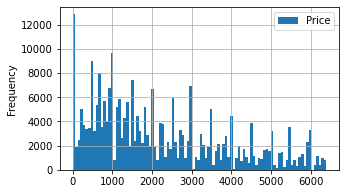

In [10]:
df.plot(y='Price', kind='hist', bins=100, grid=True, figsize=(5,3), range=(0,6400))

Есть значения цены около 0, посмотрим внимательно на них

<AxesSubplot:ylabel='Frequency'>

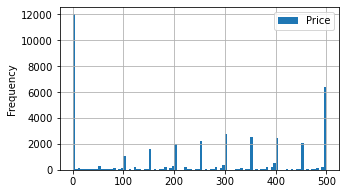

In [11]:
df.plot(y='Price', kind='hist', bins=100, grid=True, figsize=(5,3), range=(0,500))

Т.к. для наших прогнозов цена является целевым признаком, то для последующих обучений моделей такой результат неприемлим, потому необходимо избавиться от объявлений без указания цены и цены менее 50 евро

In [12]:
df = df.query('Price >= 50')

Рассмотрим следующие столбцы VehicleType, Gearbox, Model, FuelType.

Т.к. во всех из них есть пропуски данных и их мы не можем восстановить по какому-нибудь похожему признаку, потому как в разные годы (и в течении одного года выпуска) автомобили одной марки могли выпускаться с разными типами кузовов, с разными коробками передач, с разными двигателями и типом топлива заменим пропущенные значения на 'unknown'

Аналогичная ситуация и со столбцом NotRepaired.

Из-за отсутствия данных, мы не можем подставить туда ни "да" ни "нет".

In [13]:
df['VehicleType'].fillna('unknown', inplace=True)
df['Gearbox'].fillna('unknown', inplace=True)
df['Model'].fillna('unknown', inplace=True)
df['FuelType'] = df['FuelType'].replace({'petrol' : 'gasoline'})
df['FuelType'].fillna('unknown', inplace=True)
df['NotRepaired'].fillna('unknown', inplace=True)

Рассмотрим данные в столбце Power

In [14]:
df['Power'].describe()

count    341946.000000
mean        111.207240
std         188.253725
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Видим нулевые значения и максимальное количество авто по мощности сконцентрировано в диапазоне от 0 до 250. Рассмотрим распределение.

<AxesSubplot:ylabel='Frequency'>

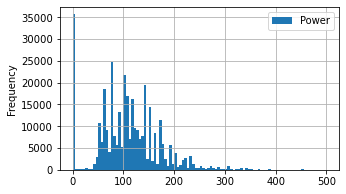

In [15]:
df.plot(y='Power', kind='hist', bins=100, grid=True, figsize=(5,3), range=(0,500))

Мы видим, что много значений с нулевой мощностью и единичные значения с мощностью более 400-т. Заменить мы их ничем не сможем, поэтому избавимся от них.

In [16]:
df = df.query('0 < Power < 400')

Рассмотрим данные в столбце RegistrationYear

In [17]:
df['RegistrationYear'].describe()

count    305671.000000
mean       2003.481472
std          29.156012
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Видим, что данные начинаются с 1000 года по 9999 год. Посмотрим поближе

<AxesSubplot:ylabel='Frequency'>

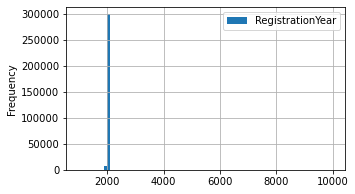

In [18]:
df.plot(y='RegistrationYear', kind='hist', bins=100, grid=True, figsize=(5,3), range=(1000,9999))

Концентрация данных по году выпуска сосредоточена около 2000 годов

<AxesSubplot:ylabel='Frequency'>

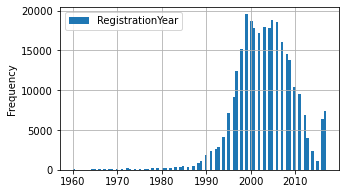

In [19]:
df.plot(y='RegistrationYear', kind='hist', bins=100, grid=True, figsize=(5,3), range=(1960,2017))

В данных вне диапазона 1960 -2017 либо ошибки при внесении либо вбросы. Даже, если это не вбросы, масовый сегмент предсказаний мы видим из гистограммы. Избавимся от них

In [20]:
df = df.query('1960 < RegistrationYear < 2017')

В дальнейшем обучении моделей столбец DateCreated не несет никакой смысловой нагрузки, избавимся от него

In [21]:
df = df.drop(['DateCreated'], axis=1)

Удалим дубликаты

In [22]:
df = df.drop_duplicates().reset_index(drop=True)

Посмотрим на полученные данные

In [23]:
first_look(df)

------------- Первые 5 строк ------------


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,10,gasoline,bmw,yes




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272018 entries, 0 to 272017
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              272018 non-null  int64 
 1   VehicleType        272018 non-null  object
 2   RegistrationYear   272018 non-null  int64 
 3   Gearbox            272018 non-null  object
 4   Power              272018 non-null  int64 
 5   Model              272018 non-null  object
 6   Kilometer          272018 non-null  int64 
 7   RegistrationMonth  272018 non-null  int64 
 8   FuelType           272018 non-null  object
 9   Brand              272018 non-null  object
 10  NotRepaired        272018 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.8+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ











------------- Категориальные признаки ------------


На данном этапе мы ознакомидись с данными, избавились от пустых значений, вбросов и дубликатов

<a id="step_3"></a>
## Обучение моделей

Функция разбиения выборок на обучающую, валидационную и тестовую в соотношении 60:20:20

In [24]:
def split(df: pd.DataFrame) -> pd.array:
    features_train, features_test, target_train, target_test = train_test_split(
        df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=12345
    )
    return features_train, features_test, target_train, target_test

Т.к проверка наших моделей будет осуществляться метрикой RMSE, создадим для нее функцию и определим переменной scorer ссылку на объект с наилучшим результатом

In [25]:
def rmse_score(target: pd.array, predictions: pd.array) -> float:
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

In [26]:
scorer = make_scorer(rmse_score, greater_is_better=False)

Функция обучения наших моделей, поиска наилучшей метрики RMSE и подобранных параметров

In [27]:
def model_look(model: Any, parameters: list, features_train: pd.array, target_train: pd.array):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

In [28]:
type(LinearRegression())

sklearn.linear_model._base.LinearRegression

Преобразуем категориальные данные методом прямого кодирования для обучения модели линейной регриссии

In [29]:
df_ohe = df.copy
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,18300,2011,190,125000,5,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,9800,2004,163,125000,8,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1500,2001,75,150000,6,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,3600,2008,69,90000,7,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,650,1995,102,150000,10,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [30]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = split(df_ohe)

<a id="step_4"></a>
Обучим модель линейной регрессии и узнаем лучшую метрику RMSE и параметры

In [31]:
parameters = {'fit_intercept':[True,False], 'positive':[True,False]}
rmse, best_parameters = model_look(LinearRegression(), parameters, features_train_lr, target_train_lr)
display('Лучшие параметры модели линейной регрессии:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END fit_intercept=True, positive=True;, score=-2963.345 total time=  24.0s
[CV 2/5] END fit_intercept=True, positive=True;, score=-2918.498 total time=  23.8s
[CV 3/5] END fit_intercept=True, positive=True;, score=-2935.196 total time=  23.9s
[CV 4/5] END fit_intercept=True, positive=True;, score=-2918.964 total time=  24.1s
[CV 5/5] END fit_intercept=True, positive=True;, score=-2950.308 total time=  25.4s
[CV 1/5] END fit_intercept=True, positive=False;, score=-2618.767 total time=  13.8s
[CV 2/5] END fit_intercept=True, positive=False;, score=-2578.613 total time=  11.3s
[CV 3/5] END fit_intercept=True, positive=False;, score=-2592.473 total time=   8.3s
[CV 4/5] END fit_intercept=True, positive=False;, score=-2569.052 total time=   8.6s
[CV 5/5] END fit_intercept=True, positive=False;, score=-2597.335 total time=   8.3s
[CV 1/5] END fit_intercept=False, positive=True;, score=-3573.889 total time=  22.3s
[CV 2/5] E

'Лучшие параметры модели линейной регрессии:'

{'fit_intercept': True, 'positive': False}

'Дали RMSE модели:'

-2591.248126856851

In [32]:
results = pd.DataFrame(
    {
        'model':['LinearRegression'],
        'best_parameters_train':[best_parameters],
        'RMSE_train':[rmse]
    }
)

In [33]:
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127


<a id="step_5"></a>
Проверим работу модели предсказаний на моделе дерева решений. Т.к. для деревянных моделей подходит больше кодирование признаков порядковым кодированием, подготовим дланные

In [34]:
cat_columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Brand', 'Model']
encoder = OrdinalEncoder()
df_ordinal = df.copy()
df_ordinal[cat_columns] = encoder.fit_transform(df_ordinal[cat_columns])
df_ordinal.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,18300,2.0,2011,1.0,190,227.0,125000,5,2.0,1.0,2.0
1,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
2,1500,5.0,2001,1.0,75,116.0,150000,6,2.0,38.0,0.0
3,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
4,650,4.0,1995,1.0,102,11.0,150000,10,2.0,2.0,2.0


In [35]:
features_train_tree, features_test_tree, target_train_tree, target_test_tree\
    = split(df_ordinal)

In [36]:
parameters = {'max_depth': range(18,21), 'min_samples_split': range(44,47)}
rmse, best_parameters = model_look(DecisionTreeRegressor(random_state=12345),\
                                    parameters, features_train_tree, target_train_tree)
display('Лучшие параметры модели дерева решений:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_depth=18, min_samples_split=44;, score=-1833.482 total time=   0.4s
[CV 2/5] END max_depth=18, min_samples_split=44;, score=-1827.855 total time=   0.6s
[CV 3/5] END max_depth=18, min_samples_split=44;, score=-1840.526 total time=   0.6s
[CV 4/5] END max_depth=18, min_samples_split=44;, score=-1801.166 total time=   0.4s
[CV 5/5] END max_depth=18, min_samples_split=44;, score=-1803.803 total time=   0.4s
[CV 1/5] END max_depth=18, min_samples_split=45;, score=-1835.200 total time=   0.4s
[CV 2/5] END max_depth=18, min_samples_split=45;, score=-1826.168 total time=   0.4s
[CV 3/5] END max_depth=18, min_samples_split=45;, score=-1834.865 total time=   0.5s
[CV 4/5] END max_depth=18, min_samples_split=45;, score=-1800.279 total time=   0.5s
[CV 5/5] END max_depth=18, min_samples_split=45;, score=-1800.255 total time=   0.6s
[CV 1/5] END max_depth=18, min_samples_split=46;, score=-1833.779 total time=   0.6s
[CV 2

'Лучшие параметры модели дерева решений:'

{'max_depth': 19, 'min_samples_split': 45}

'Дали RMSE модели:'

-1818.96606439004

In [37]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'DecisionTreeRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064


<a id="step_6"></a>
Проверим работу модели предсказаний на моделе случайного леса

In [38]:
parameters = {'n_estimators': range(143, 146, 1), 'max_depth': range(17,20, 1)}
rmse, best_parameters = model_look(RandomForestRegressor(random_state=12345), \
                                    parameters, features_train_tree, target_train_tree)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_depth=17, n_estimators=143;, score=-1651.975 total time=  52.5s
[CV 2/5] END max_depth=17, n_estimators=143;, score=-1641.628 total time=  52.9s
[CV 3/5] END max_depth=17, n_estimators=143;, score=-1634.740 total time=  54.4s
[CV 4/5] END max_depth=17, n_estimators=143;, score=-1622.702 total time=  49.2s
[CV 5/5] END max_depth=17, n_estimators=143;, score=-1620.016 total time=  49.6s
[CV 1/5] END max_depth=17, n_estimators=144;, score=-1651.987 total time=  48.9s
[CV 2/5] END max_depth=17, n_estimators=144;, score=-1641.576 total time=  49.1s
[CV 3/5] END max_depth=17, n_estimators=144;, score=-1634.739 total time=  49.3s
[CV 4/5] END max_depth=17, n_estimators=144;, score=-1622.649 total time=  49.5s
[CV 5/5] END max_depth=17, n_estimators=144;, score=-1619.994 total time=  49.2s
[CV 1/5] END max_depth=17, n_estimators=145;, score=-1652.149 total time=  48.9s
[CV 2/5] END max_depth=17, n_estimators=145;, sco

'Лучшие параметры модели случайного леса:'

{'max_depth': 18, 'n_estimators': 144}

'Дали RMSE модели:'

-1632.0294017113279

In [39]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'RandomForestRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402


<a id="step_7"></a>
Проверим работу модели предсказаний на моделе CatBoostRegressor. Для этого переведем значения категориальных столбцов в тип 'category'

In [40]:
df_catboost = df.copy()
for columns in cat_columns:
    df_catboost[columns] = df_catboost[columns].astype('category')
df_catboost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272018 entries, 0 to 272017
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              272018 non-null  int64   
 1   VehicleType        272018 non-null  category
 2   RegistrationYear   272018 non-null  int64   
 3   Gearbox            272018 non-null  category
 4   Power              272018 non-null  int64   
 5   Model              272018 non-null  category
 6   Kilometer          272018 non-null  int64   
 7   RegistrationMonth  272018 non-null  int64   
 8   FuelType           272018 non-null  category
 9   Brand              272018 non-null  category
 10  NotRepaired        272018 non-null  category
dtypes: category(6), int64(5)
memory usage: 12.2 MB


In [41]:
features_train, features_test, target_train, target_test = split(df_catboost)

In [42]:
parameters = {'depth': range(5, 9, 1), 'iterations': range(900, 1200, 100)}
rmse, best_parameters = model_look(
    CatBoostRegressor(
        cat_features=cat_columns,
        loss_function="RMSE",
        learning_rate=0.5,
        logging_level='Silent'),
    parameters, features_train, target_train
)
display('Лучшие параметры модели CatBoostRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .......depth=5, iterations=900;, score=-1595.534 total time=  19.9s
[CV 2/5] END .......depth=5, iterations=900;, score=-1601.799 total time=  19.8s
[CV 3/5] END .......depth=5, iterations=900;, score=-1579.956 total time=  19.8s
[CV 4/5] END .......depth=5, iterations=900;, score=-1588.779 total time=  19.8s
[CV 5/5] END .......depth=5, iterations=900;, score=-1575.694 total time=  19.2s
[CV 1/5] END ......depth=5, iterations=1000;, score=-1592.457 total time=  21.7s
[CV 2/5] END ......depth=5, iterations=1000;, score=-1599.585 total time=  21.9s
[CV 3/5] END ......depth=5, iterations=1000;, score=-1579.317 total time=  21.8s
[CV 4/5] END ......depth=5, iterations=1000;, score=-1586.758 total time=  21.9s
[CV 5/5] END ......depth=5, iterations=1000;, score=-1574.541 total time=  21.8s
[CV 1/5] END ......depth=5, iterations=1100;, score=-1588.355 total time=  24.0s
[CV 2/5] END ......depth=5, iterations=1100;, sc

'Лучшие параметры модели CatBoostRegressor:'

{'depth': 7, 'iterations': 1000}

'Дали RMSE модели:'

-1580.6954819236585

In [43]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'CatBoostRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482


<a id="step_8"></a>
Проверим работу модели предсказаний на моделе LGBMRegressor.

In [44]:
parameters = {'n_estimators': range(2048, 2051)}
rmse, best_parameters = model_look(
    LGBMRegressor(random_state=12345, verbose=-1), parameters, features_train, target_train
)
display('Лучшие параметры модели LGBMRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............n_estimators=2048;, score=-1538.869 total time=   3.7s
[CV 2/5] END .............n_estimators=2048;, score=-1551.773 total time=   3.7s
[CV 3/5] END .............n_estimators=2048;, score=-1534.529 total time=   3.7s
[CV 4/5] END .............n_estimators=2048;, score=-1530.935 total time=   3.6s
[CV 5/5] END .............n_estimators=2048;, score=-1530.603 total time=   4.0s
[CV 1/5] END .............n_estimators=2049;, score=-1538.871 total time=   4.3s
[CV 2/5] END .............n_estimators=2049;, score=-1551.760 total time=   4.4s
[CV 3/5] END .............n_estimators=2049;, score=-1534.510 total time=   4.3s
[CV 4/5] END .............n_estimators=2049;, score=-1530.952 total time=   4.2s
[CV 5/5] END .............n_estimators=2049;, score=-1530.534 total time=   4.0s
[CV 1/5] END .............n_estimators=2050;, score=-1538.863 total time=   4.2s
[CV 2/5] END .............n_estimators=2050;, sco

'Лучшие параметры модели LGBMRegressor:'

{'n_estimators': 2049}

'Дали RMSE модели:'

-1537.3255005494743

In [45]:
results = pd.concat(
    [
        results, pd.DataFrame({
        'model':'LGBMRegressor',
        'best_parameters_train':[best_parameters],
        'RMSE_train':rmse
    })
    ], ignore_index=True
)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482
4,LGBMRegressor,{'n_estimators': 2049},-1537.325501


На данном этапе мы выяснили какую метрику выдают модели предсказаний и их лучшие параментры. Необходимо все это проверить на тестовой выборке

<a id="step_9"></a>
## Анализ моделей

Создадим функцию для обучения, хронометража обучения и предсказания моделей

In [46]:
def ml_result(model, features_train, target_train, features_test, target_test):
        
    fit_up = time.time()
    model.fit(features_train, target_train)
    fit_down = time.time()
    
    fit_time = fit_down - fit_up
    
    predict_up = time.time()
    predictions = model.predict(features_test)
    predict_down = time.time()
    
    predict_time = predict_down - predict_up
    
    rmse = mean_squared_error(target_test, predictions)**0.5
      
    return fit_time, predict_time, rmse

Проверим модель линейной регрессии

In [47]:
fit_time, predict_time, rmse = ml_result(
    LinearRegression(fit_intercept=True, positive=False),
    features_train_lr,
    target_train_lr,
    features_test_lr,
    target_test_lr
)
results.loc[0, 'fit_time'] = fit_time
results.loc[0, 'predict_time'] = predict_time
results.loc[0, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127,4.11383,0.184911,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,NaN,NaN,NaN
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 2049},-1537.325501,NaN,NaN,NaN


Проверим модель дерева решений

In [48]:
fit_time, predict_time, rmse = ml_result(
    DecisionTreeRegressor(random_state=12345,
                          max_depth=19,
                          min_samples_split=45),
    features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[1, 'fit_time'] = fit_time
results.loc[1, 'predict_time'] = predict_time
results.loc[1, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127,4.113830,0.184911,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.570514,0.014742,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 2049},-1537.325501,NaN,NaN,NaN


Проверим модель случайного дерева

In [49]:
fit_time, predict_time, rmse = ml_result(
    RandomForestRegressor(random_state=12345,
                          max_depth=18,
                          n_estimators=144),
    features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[2, 'fit_time'] = fit_time
results.loc[2, 'predict_time'] = predict_time
results.loc[2, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127,4.113830,0.184911,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.570514,0.014742,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,62.678294,2.242072,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 2049},-1537.325501,NaN,NaN,NaN


Проверим модель CatBoostRegressor

In [50]:
fit_time, predict_time, rmse = ml_result(
    CatBoostRegressor(
        cat_features=cat_columns,
        loss_function="RMSE",
        learning_rate = 0.5,
        depth=7,
        iterations=1000,
        logging_level='Silent'),
    features_train, target_train, features_test, target_test)
results.loc[3, 'fit_time'] = fit_time
results.loc[3, 'predict_time'] = predict_time
results.loc[3, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127,4.113830,0.184911,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.570514,0.014742,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,62.678294,2.242072,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,39.842552,0.129552,1552.117225
4,LGBMRegressor,{'n_estimators': 2049},-1537.325501,NaN,NaN,NaN


Проверим модель LGBMRegressor

In [51]:
fit_time, predict_time, rmse = ml_result(
    LGBMRegressor(
        random_state=12345,
        n_estimators=2049,
        verbose=-1),
    features_train, target_train, features_test, target_test
)
results.loc[4, 'fit_time'] = fit_time
results.loc[4, 'predict_time'] = predict_time
results.loc[4, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'positive': False}",-2591.248127,4.113830,0.184911,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.570514,0.014742,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,62.678294,2.242072,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,39.842552,0.129552,1552.117225
4,LGBMRegressor,{'n_estimators': 2049},-1537.325501,3.932717,0.926979,1506.268582


<a id="step_10"></a>
Вывод по данному этапу:

На данном этапе мы проверили наши модели с полученными ранее гиперпараметрами на тесвой выборке.

Лучшая с точки зрения качества предсказания - модель LGBMRegressor

Наименьшее время обучения - модель DecisionTreeRegressor

Наменьшее время предсказания - модель DecisionTreeRegressor

<a id="step_11"></a>
## Общий вывод

По полученным результатам я бы рекомендовал модель LGBMRegressor, как соотношение качества предсказания ко времени обучения и предсказания.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей